In [105]:
with_background = T
source('functions.R')


library(ggrepel)
min_max_norm = function(x) (x-min(x))/(max(x)-min(x))
scale_p = function(x) pnorm(scale(x),lower.tail=F)
z_score = function(x,var,null){
    x_out = x
    for(i in 1:length(x)){  #### or split by linkage
        #x_out[i] = (x[i] - mean(null[i,var,],na.rm=T))/(sd(null[i,var,],na.rm=T))
        x_out[i] = (x[i] - mean(null[i,var,],na.rm=T))/(sd(null[i,var,],na.rm=T)/sqrt(length(na.omit(null[i,var,]))))
    }
    return(x_out)
}
# pooled scores
poolsump<-function(x,y){
    x=na.omit(x);	xsum=sum(x);	xlen=length(x);
    y=na.omit(y);	ysum=sum(y);	ylen=length(y);
    #print('-'); print(x); print(y)
    xy=c(xsum/xlen,ysum/ylen)
    #print(xy); print(pnorm(xy+1e-100,lower.tail=F))
    sumlog(pnorm(xy,lower.tail=F)+1e-100)$p+1e-100
}

rm_genes = c('POFUT1b','POFUT2a','POFUT2b','FUT8')
linkage_orig = load_linkages()
### 8/1/19, added ST3GAL1 bc it is gal-galnac specific, and B3GALNT2 bc it is a glcnac transferase (not relevant)
linkage = linkage_update(linkage_orig)
linkage

######### load
load('data_out/Gene_Choice.rda')
load('/media/ben/9c17f1c9-a45e-49ec-b547-8fbd2f25ccc6/HMO_biosynthesis.RAND/nulldistr.rda')
dataset = sapply(strsplit(dimnames(distr)[[1]],'_'),function(x) x[1])
################


str(distr)

[[1]]
[1] "B3GNT2" "B3GNT3" "B3GNT8"

[[2]]
[1] "FUT2"

[[3]]
[1] "FUT11" "FUT3"  "FUT4"  "FUT6b"

[[4]]
[1] "ST3GAL1a" "ST3GAL3b" "ST3GAL5b"

[[5]]
[1] "ST6GAL1b"

[[6]]
[1] "B3GALT4" "B3GALT5"

[[7]]
[1] "B4GALT1"  "B4GALT2a" "B4GALT3"  "B4GALT4a"

[[8]]
[1] "GCNT1"  "GCNT2c" "GCNT3" 

[[9]]
[1] "FUT3"

[[10]]
[1] "ST6GALNAC2"  "ST6GALNAC4a" "ST6GALNAC6"

 num [1:50, 1:3, 1:88] 0.727 0.141 0.131 1 0.603 ...
 - attr(*, "dimnames")=List of 3
  ..$ : chr [1:50] "d1_L1_b3GnT_B3GNT2" "d1_L1_b3GnT_B3GNT3" "d1_L1_b3GnT_B3GNT8" "d1_L2_a2FucT_FUT2" ...
  ..$ : chr [1:3] "PROP" "GLS" "MSC"
  ..$ : NULL


In [106]:
# Enrichment
enrich_d1 = Gene_Choice[[1]][,c('rxn_name','selection_inter_size','selection_inter_success','enrichment_inter')]
rownames(enrich_d1) = enrich_d1$rxn_name
enrich_d1$PROP = enrich_d1$selection_inter_success / enrich_d1$selection_inter_size

enrich_d2 = Gene_Choice[[2]][,c('rxn_name','selection_inter_size','selection_inter_success','enrichment_inter')]
rownames(enrich_d2) = enrich_d2$rxn_name
enrich_d2$PROP = enrich_d2$selection_inter_success / enrich_d2$selection_inter_size

data_all_1 = data.frame( enrich_d1[,c('PROP','enrichment_inter')] )
data_all_2 = data.frame( enrich_d2[,c('PROP','enrichment_inter')])



In [107]:
# integrate null distribution
model_count = 45e6
#	enrich_d1$enrichment = phyper( enrich_d1$selection_success-1 , m = enrich_d1$background_success , n = enrich_d1$background_failure , k = enrich_d1$selection_size ,lower.tail=F)
#	enrich_d1$enrichment_inter = phyper( enrich_d1$selection_inter_success-1 , m = null_selected*.05 , n = null_selected*.95 , k = enrich_d1$selection_inter_size ,lower.tail=F)
#	enrich_d1$enrichment = phyper( enrich_d1$selection_inter_success-1 , m = round(rowMeans(distr[,'selection_inter_success',],na.rm=T)) , n = 15e6-round(rowMeans(distr[,'selection_inter_success',],na.rm=T)) , k = enrich_d1$selection_inter_size ,lower.tail=F)
data_all_1$enrichment_inter = phyper( enrich_d1$selection_inter_success-1 , m = round(model_count*rowMeans(distr[dataset=='d1','PROP',])) , n = round(model_count*(1-rowMeans(distr[dataset=='d1','PROP',]))) , k = enrich_d1$selection_inter_size ,lower.tail=F)
data_all_2$enrichment_inter = phyper( enrich_d2$selection_inter_success-1 , m = round(model_count*rowMeans(distr[dataset=='d2','PROP',])) , n = round(model_count*(1-rowMeans(distr[dataset=='d2','PROP',]))) , k = enrich_d2$selection_inter_size ,lower.tail=F)
#data_all_2$enrichment_inter = phyper( enrich_d2$selection_inter_success-1 , m = null_selected*.05 , n = null_selected*.95 , k = enrich_d2$selection_inter_size ,lower.tail=F)
if(with_background){
    data_all_1$PROP_z = pnorm( z_score( enrich_d1$PROP,'PROP',distr[dataset=='d1',,]) , lower.tail=F)
    data_all_2$PROP_z = pnorm( z_score( enrich_d2$PROP,'PROP',distr[dataset=='d2',,]) , lower.tail=F)
}
####

data_all_1r = data_all_1
data_all_2r = data_all_2

if(with_background){
    data_all_1b = data.frame( PROP=z_score( enrich_d1$PROP,'PROP',distr[dataset=='d1',,])  )
    data_all_2b = data.frame( PROP=z_score( enrich_d2$PROP,'PROP',distr[dataset=='d2',,])  )
    #data_all_1b = data.frame( scale(enrich_d1[,c('PROP','enrichment_inter')] ))
    #data_all_2b = data.frame( scale(enrich_d2[,c('PROP','enrichment_inter')]))
}

In [108]:
# Get Commonly Selected Models
########### load
Model_Score_Groups = attach.big.matrix('Model_Score_Groups.desc')
#####################
common = which( Model_Score_Groups[,1] & Model_Score_Groups[,2] )


# Gene Linkage Score (min-max normalized median GLS)
###########load 
DS = c('data1','data2') #,'data1_secretor','data2_secretor')
Gene_Linkage_Scores = lapply( DS,function(x) dget( paste0("gene_linkage_score.",x,".desc") ) ) 
#################
gls_d1 = attach.big.matrix(Gene_Linkage_Scores[[1]])[common,]
tmp = apply(gls_d1,2,median,na.rm=T)
data_all_1r$GLS = tmp
data_all_1$GLS = min_max_norm(tmp)
if(with_background){
    data_all_1b$GLS = z_score(tmp,'GLS',distr[dataset=='d1',,])
}
#	data_all_1b$GLS = scale(tmp)

gls_d2 = attach.big.matrix(Gene_Linkage_Scores[[2]])[common,]
tmp = apply(gls_d2,2,median,na.rm=T)
data_all_2r$GLS = tmp
data_all_2$GLS = min_max_norm(tmp)
if(with_background){
    data_all_2b$GLS = z_score(tmp,'GLS',distr[dataset=='d2',,])
}
#data_all_2b$GLS = scale(tmp)

In [109]:
# Model Score Contribution: correlation of model score to GLS in commonly selected models (max-min normalized)
##### load
Model_Scores = attach.big.matrix('Model_Scores.desc')[common,1:2]
##############
tmp = apply(gls_d1,2,function(x) cor(Model_Scores[,1] , x , method='pearson'))
data_all_1r$MSC = tmp
data_all_1$MSC = min_max_norm(tmp)
if(with_background){
    data_all_1b$MSC = z_score(tmp,'MSC',distr[dataset=='d1',,])
}
#data_all_1b$MSC = scale(tmp)

tmp = apply(gls_d2,2,function(x) cor(Model_Scores[,2] , x , method='pearson'))
data_all_2r$MSC = tmp
data_all_2$MSC = min_max_norm(tmp)
if(with_background){
    data_all_2b$MSC = z_score(tmp,'MSC',distr[dataset=='d2',,])
    #data_all_2b$MSC = scale(tmp)
}

In [110]:
# Name
data_all_1$dataset = 'd1'
data_all_2$dataset = 'd2'
if(with_background){
    data_all_1b$dataset = 'd1'
    data_all_2b$dataset = 'd2'
}
data_all_1r$dataset = 'd1'
data_all_2r$dataset = 'd2'

labs = data.frame( do.call(rbind,strsplit(gsub('_gene','',rownames(data_all_1)),'_')) )
colnames(labs) = c('Linkage','Link','Gene')

data_all = rbind(data_all_1,data_all_2)
data_all = cbind(data_all,rbind(labs,labs))

if(with_background){
data_allb = rbind(data_all_1b,data_all_2b)
data_allb = cbind(data_allb,rbind(labs,labs))
}else{data_allb=NULL}

data_allr = rbind(data_all_1r,data_all_2r)
data_allr = cbind(data_allr,rbind(labs,labs))

save(data_all,data_allb,data_allr,file='data_out/Gene_Choice_aggstats.rda')

# data_all_1b = cbind(data.frame(data_all_1b),labs)
# data_all_2b = cbind(data.frame(data_all_2b),labs)
# data_allb = cbind(melt(data_all_1b[,-2],id.vars=c('Linkage','Link','Gene')),
# 	melt(data_all_2b[,-2],id.vars=c('Linkage','Link','Gene')))[,-(6:9)]



In [111]:
data_allb[grepl('B4GALT4',data_allb$Gene),]

,PROP,GLS,MSC,dataset,Linkage,Link,Gene
,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<fct>
18,43.62005,12.39687,14.19506,d1,L7,b4GalT,B4GALT4a
43,54.10565,25.50014,14.56752,d2,L7,b4GalT,B4GALT4a


TableGrob (3 x 3) "arrange": 9 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]
4 4 (2-2,1-1) arrange gtable[layout]
5 5 (2-2,2-2) arrange gtable[layout]
6 6 (2-2,3-3) arrange gtable[layout]
7 7 (3-3,1-1) arrange gtable[layout]
8 8 (3-3,2-2) arrange gtable[layout]
9 9 (3-3,3-3) arrange gtable[layout]

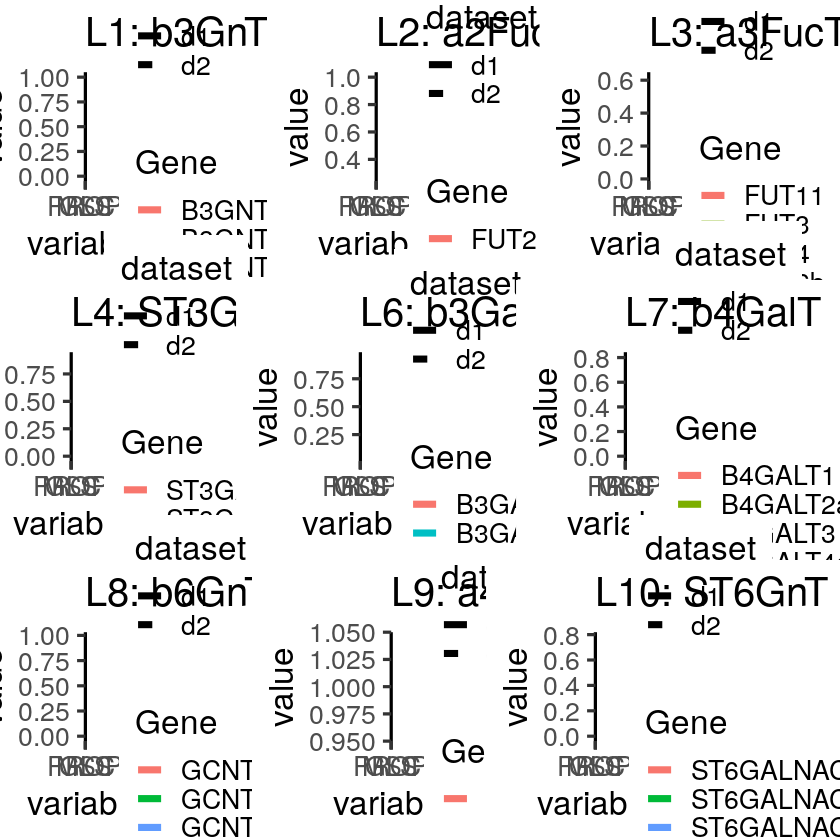

In [112]:
## parallel coord
library(GGally)

m=melt( data_all[,-(2:3)] , id.vars=c('dataset','Linkage','Link','Gene'))
m=melt( data_all[,-(2:3)] , id.vars=c('dataset','Linkage','Link','Gene'))

library(gridExtra)
g=grid.arrange(grobs=lapply(paste0('L',1:10)[-5],function(l){
    t = paste(unlist(unique(m[m$Linkage==l,c('Linkage','Link')])),collapse=': ')
    ggplot(m[m$Linkage==l,],aes(x=variable,y=value,group=paste(Gene,dataset),color=Gene,linetype=dataset))+
        geom_path(size=2)+theme_classic(base_size=20)+ggtitle(t)
    }))
g
ggsave(g,filename='figures/pooled_gene_choice.pdf',height=18,width=20)



Warning message:
“Width not defined. Set with `position_dodge(width = ?)`”Warning message:
“Width not defined. Set with `position_dodge(width = ?)`”Using  as id variables


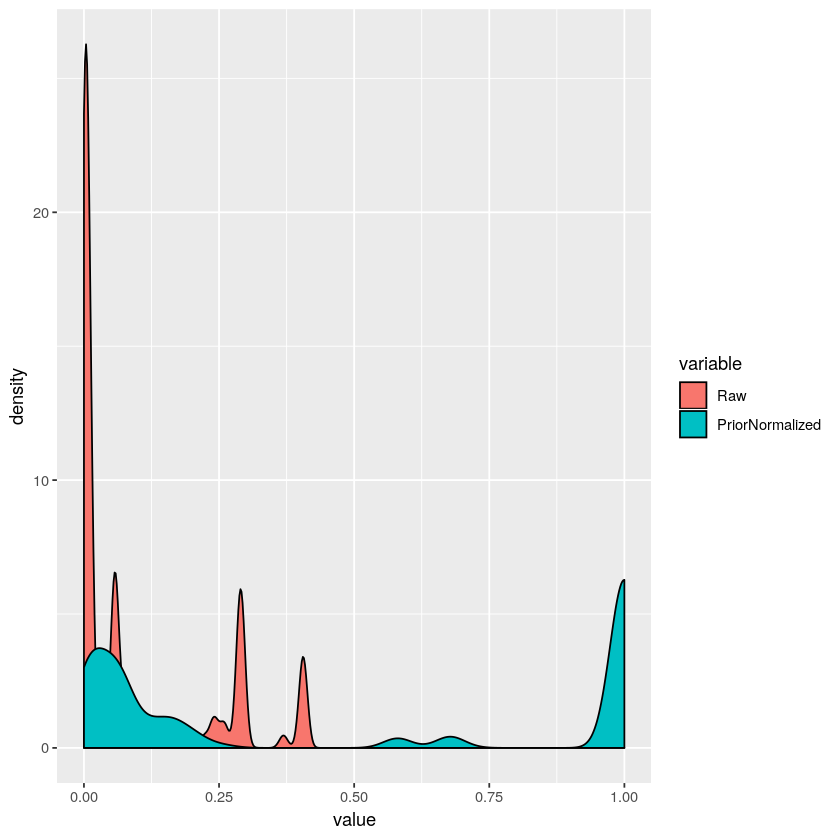

In [113]:
if(with_background){
mb=melt( data_allb , id.vars=c('dataset','Linkage','Link','Gene'))
#df2 = mb %>% group_by(Linkage,Link,Gene) %>% summarize( Pr=poolsump( val=value,ds=dataset ))
df2 = mb %>% group_by(Linkage,Link,Gene) %>% summarize( Pr=poolsump( x=value[dataset=='d1'] , y=value[dataset=='d2'] ))
#df2 = mb %>% group_by(Linkage,Link,Gene) %>% summarize( Pr=pnorm( (sum(value[dataset=='d1'])/length(value[dataset=='d1'])) ,lower.tail=F)+1e-100 )
# df=aggregate(mb$value,list(mb$Linkage,mb$Link,mb$Gene),paste,collapse='_')  
# df2=aggregate(df$x,list(df$Group.1,df$Group.2,df$Group.3),function(x){
# 	sumlog(pnorm(x/3,lower.tail=F))$p
# 	})
df2 = as.data.frame(df2)

# colnames(df2)=c('Linkage','Link','Gene','Pr')
df2$fdr = p.adjust(df2$Pr,'fdr')

##########################################################################
###  add indication of non-expressed genes 
df2=rbind(df2,data.frame(Linkage=c('L5','L9'),Link=c('ST6Gal','a4FucT'),Gene=c('ST6GAL2','FUT5'),Pr=c(1,1),fdr=c(1,1)))
##########################################################################
##########################################################################

labi = factor(paste(df2$Linkage,df2$Link,sep='_') )
ord =  order(unlist(lapply(strsplit(levels(labi),'_'),function(x) as.numeric(gsub('L','',x[1])) )))
df2$lab = factor( as.character(labi) , levels = levels(labi)[ord])

g=ggplot( df2,aes(x=lab,y=-log(Pr,10)+.01,color=-log(Pr,10),size=-log(Pr,10),label=Gene))+#geom_label()
    geom_text_repel(size=5)+geom_point(position=position_dodge())+ #scale_color_manual(values=c('darkgrey','darkred'))+#geom_point()+
    theme_bw(base_size=25)+ theme(axis.text.x = element_text(angle = 45, hjust = 1))+scale_y_log10()+
    geom_hline(yintercept=1)#+ggtitle('Joint P-value for ')
ggsave(g,filename='figures/join_pooled_gene_choice.pdf',height=7,width=16)

g=ggplot( df2,aes(x=lab,y=-log(fdr,10)+.01,color=-log(fdr,10),size=-log(fdr,10),label=Gene))+#geom_label()
    geom_text_repel(size=5)+geom_point(position=position_dodge())+ #scale_color_manual(values=c('darkgrey','darkred'))+#geom_point()+
    theme_bw(base_size=25)+ theme(axis.text.x = element_text(angle = 45, hjust = 1))+scale_y_log10()+
    geom_hline(yintercept=1)#+ggtitle('Joint P-value for ')
ggsave(g,filename='figures/join_pooled_gene_choice.fdr.pdf',height=7,width=16)

# ggplot( df2,aes(x=paste(Group.1,Group.2,sep='_'),y=2^x,size=2^x,label=Group.3,group=Group.3))+#geom_label()
# 	geom_text_repel(size=5)+geom_point(position=position_dodge())+ #scale_color_manual(values=c('darkgrey','darkred'))+#geom_point()+
# 	theme_bw(base_size=15)#+scale_y_log10()

#df= dcast( Linkage+Link+Gene+variable~dataset,data=mb,value.var='value')
# df = data_allb
# colnames(df)[5:6] = c('d1','d2')
# df$score = pnorm(df$d1,lower.tail=F)*pnorm(df$d2,lower.tail=F)
# ggplot(df,aes(x=d1,y=d2,size=-log(score,10),label=Gene,color=paste(Linkage,Link,sep='_')))+
# 	geom_text_repel()+scale_y_log10()+scale_x_log10()

# proportion

data_all$enriched = ifelse(data_all$enrichment_inter>0.05,'',ifelse(data_all$enrichment_inter>0.001,'p < 0.05','p < 0.001') )
#	data_all$enriched = ifelse(data_all$PROP_z>0.05,'',ifelse(data_all$PROP_z>0.001,'p < 0.05','p < 0.001') )
data_all$ll = paste(data_all$Linkage,data_all$Link)

# g=ggplot(data_all[data_all$Linkage %in% paste0('L',c(1:4,6:8,10)),] , aes(x=ll,y=PROP,label=Gene,color=enriched))+
# 	geom_text_repel(size=5)+ scale_color_manual(values=c('darkgrey','darkred','red'))+geom_point()+
# 	theme_bw(base_size=25)
g=ggplot(data_all[data_all$Linkage %in% paste0('L',c(1:2,4,6:8)),] , aes(x=ll,y=PROP,label=Gene,color=enriched))+
    geom_text_repel(size=5)+ scale_color_manual(values=c('darkgrey','darkred','red'))+geom_point()+
    theme_bw(base_size=25)
ggsave(g,filename='figures/enrichment_gene_choice.pdf',height=5,width=16)

# vis null distr
distr_mat = melt(distr)
distr_mat = cbind(distr_mat,as.data.frame(do.call(rbind,strsplit(as.character(distr_mat$X1),'_'))))
colnames(distr_mat) = c('name','measure','iter','value','dataset','link','reaction','gene')
g=ggplot(distr_mat[!grepl('L5',distr_mat$link),],aes(x=gene,y=value,fill=measure,color=dataset))+
    geom_boxplot()+theme_classic(base_size=15)+scale_color_manual(values=c('blue','darkblue'))+scale_fill_manual(values=c('darkgrey','lightgrey','white'))+
    facet_wrap(~paste(link,reaction),scale='free')
ggsave(g,filename='figures/background.pdf',height=15,width=15)

#ggplot(data_all , aes(x=Linkage,y=prop_inter,label=Gene,color=enriched))+geom_text_repel()+theme_bw(base_size=20)
#ggplot(data_all , aes(x=Linkage,y=prop_inter,label=Gene,color=enriched,group=Gene))+geom_text_repel()+theme_bw(base_size=20)+geom_path()

### p-value distribution
ro = do.call(cbind,lapply(readMat('Anne_Richelle.Code/3 - Code_compute_Correlation/P_data1_C51-100.mat'),function(x) t(x)))
rn = do.call(cbind,lapply(readMat('data/scores_split/P_data1_C51-100_a.mat'),function(x) t(x)))

colnames(ro) = unlist(linkage_orig)
colnames(rn) = unlist(linkage_orig)

ro = ro[,colnames(ro)%in%unlist(linkage)]
rn = rn[,colnames(rn)%in%unlist(linkage)]

ro1 = sapply(c(1:4,6:10),function(l) apply(ro[,colnames(ro)%in%linkage[[l]]],1,min ) )
rn1 = sapply(c(1:4,6:10),function(l) apply(rn[,colnames(rn)%in%linkage[[l]]],1,min ) )

df = data.frame(Raw=as.vector(ro1),PriorNormalized=as.vector(rn1))
ggplot(melt(df),aes(fill=variable,x=value))+geom_density()

}


In [95]:
library("heatmap.plus")
library(RColorBrewer)

In [49]:
bluecols <- colorRampPalette(brewer.pal(9, 'Blues'))

In [53]:
d12_hmo = read.csv('data/raw/Data12.csv')[,-21]
#d12_hmo = read.csv('data/raw/motif_abundance/motif_abundance.csv')[,-1]
d12_hmo$Dataset = paste0('d',d12_hmo$Dataset)
head(d12_hmo)
tail(d12_hmo)
colnames(d12_hmo)
d12_hmo = na.omit(d12_hmo)

bluecols <- colorRampPalette(brewer.pal(9, 'Blues'))(50)


#Create dummy data
rsc = d12_hmo[,1:2]
rsc$Dataset = ifelse(rsc$Dataset=='d1','black','grey')
rsc$Pateint.ID = RColorBrewer::brewer.pal(name = 'Set3',n=length(levels(rsc$Pateint.ID)))[rsc$Pateint.ID]
rsc$DPP = bluecols[ d12_hmo$DPP ]

#Plot
pdf('figures/hmo_conc.pdf',height=10,width=10)
heatmap.plus(data.matrix(d12_hmo[,-c(1:3,20)]), RowSideCol = as.matrix(rsc))
heatmap.plus(data.matrix(log10(d12_hmo[,-c(1:3,20)]+1)), RowSideCol = as.matrix(rsc))
dev.off()
#Legend on position (40, 2)
#legend(40, 2,legend=c("Dataset","Mother","DPP"), fill=c("white", "white", "green"), border=FALSE, bty="n", y.intersp = 0.7, cex=0.7)

Dataset,Pateint.ID,DPP,X2.FL,X3FL,LNnT,X3.SL,LNT,LNFP.I,LNFP.II,LNFP.III,LSTb,LSTc,DFLNT,DSLNT,FLNH,DFLNH,FDSLNH,DSLNH,SUM
<chr>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
d1,L1,1,21765,1034,295,5781,882,3578,435,547,47,868,1973,243,99,191,313,51,38101
d1,L1,2,17207,394,327,2335,1423,5269,431,397,95,822,1309,179,52,222,8,149,30616
d1,L1,3,15841,135,748,874,3642,8313,506,144,77,1411,1622,191,91,137,66,27,33824
d1,L1,4,15213,65,735,736,3263,7990,444,77,34,1744,1877,352,147,231,118,38,33065
d1,L1,7,9739,41,381,729,3342,4547,504,64,44,497,1585,93,221,270,56,80,22193
d1,L1,14,13347,7,843,922,4587,7479,565,226,138,1496,1820,178,216,347,102,62,32337


,Dataset,Pateint.ID,DPP,X2.FL,X3FL,LNnT,X3.SL,LNT,LNFP.I,LNFP.II,LNFP.III,LSTb,LSTc,DFLNT,DSLNT,FLNH,DFLNH,FDSLNH,DSLNH,SUM
,<chr>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
53,d2,RM,1,6644.696,430.7253,577.4438,284.3510,1868.305,1904.1022,1218.7053,94.85315,98.30858,71.38831,1127.083,144.4061,163.6707,104.55390,223.80027,41.76592,"14,998.2"
54,d2,RM,2,6650.595,526.2651,638.9988,271.1382,1984.051,1767.8216,1202.9187,134.90446,83.81916,47.04512,1080.662,105.4476,249.2720,122.20309,304.95502,50.03698,"15,220.1"
55,d2,SP,1,3584.964,261.1670,1499.0266,264.9232,2542.700,959.8744,946.6201,308.87695,147.57674,27.26894,1175.374,195.6654,267.4911,45.22822,55.40158,18.84196,"12,301.0"
56,d2,SP,2,3531.604,281.7440,1306.4835,254.5985,2777.915,950.0776,822.2310,327.84417,100.37697,21.38805,1105.241,209.6202,266.1973,41.11824,70.21653,8.79732,"12,075.5"
57,d2,LD,1,5347.374,473.4826,543.5870,480.3175,1916.911,835.6230,1804.1744,123.03246,79.44146,109.36520,1493.256,233.1994,100.0106,27.15458,255.94327,85.77554,"13,908.6"
58,d2,LD,2,5706.986,426.2974,510.0753,426.9959,2239.505,1148.8557,1901.5191,194.42233,193.58529,108.65543,1689.873,240.9633,159.8083,76.41395,294.50944,106.53031,"15,425.0"


[1] "Dataset"    "Pateint.ID" "DPP"        "X2.FL"      "X3FL"      
 [6] "LNnT"       "X3.SL"      "LNT"        "LNFP.I"     "LNFP.II"   
[11] "LNFP.III"   "LSTb"       "LSTc"       "DFLNT"      "DSLNT"     
[16] "FLNH"       "DFLNH"      "FDSLNH"     "DSLNH"      "SUM"

png 
  2

In [64]:
mean(colMeans(d12_hmo[,c('LNT','LNFP.I',"LNFP.II",'LSTb')]))
mean(colMeans(d12_hmo[,c('LNnT','LNFP.III','LSTc')]))


LNT    LNFP.I   LNFP.II      LSTb 
3251.4158 2325.4067 1835.9801  112.0626

LNnT LNFP.III     LSTc 
695.9878 120.9529 648.2015

In [71]:
apply(d12_hmo[,c('LNT','LNFP.I',"LNFP.II",'LSTb')],2,function(x) quantile(x / rowSums(d12_hmo[,-c(1:3,20)])))
apply(d12_hmo[,c('LNnT','LNFP.III','LSTc')],2,function(x) quantile(x / rowSums(d12_hmo[,-c(1:3,20)])))
#quantile(rowSums(d12_hmo[,c('LNnT','LNFP.III','LSTc')]) / rowSums(d12_hmo[,-c(1:3,20)]))

,LNT,LNFP.I,LNFP.II,LSTb
0%,0.01250961,0.01412429,0.01141672,0.001028309
25%,0.11689550,0.02176776,0.02993615,0.002487768
50%,0.15347344,0.09390583,0.07452933,0.004500449
75%,0.23329618,0.15792329,0.23860549,0.010922612
100%,0.60790933,0.24576497,0.42435226,0.029431495


,LNnT,LNFP.III,LSTc
0%,0.0009956124,6.222001e-05,0.001771201
25%,0.0222296153,2.328817e-03,0.015178050
50%,0.0333137873,4.058325e-03,0.026807018
75%,0.0472058589,8.863553e-03,0.047641181
100%,0.1218621776,2.900641e-02,0.077518113
